In [1]:
import os
import random
import cv2 as cv
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.applications import ResNet50, DenseNet121, VGG19
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from tensorflow.keras.layers import Conv2D, Flatten, Dense, Dropout, MaxPool2D, BatchNormalization

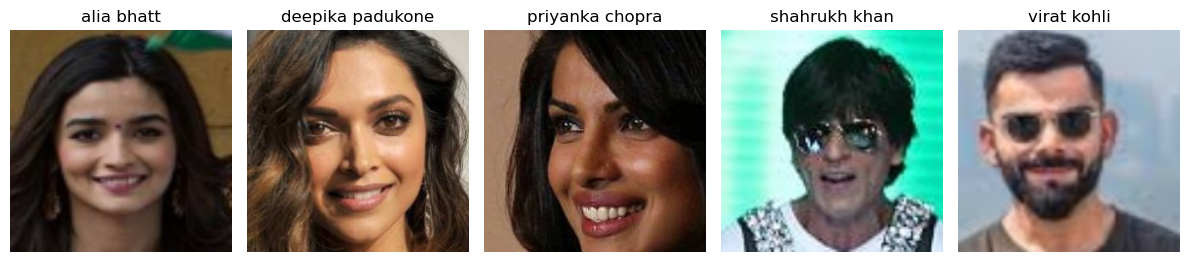

In [2]:
def display_one_image_per_class(data_dir, img_size=(224, 224)):

    class_folders = [f for f in os.listdir(data_dir) if os.path.isdir(os.path.join(data_dir, f))]
    
    plt.figure(figsize=(12, 8))

    for i, class_folder in enumerate(class_folders):
        class_path = os.path.join(data_dir, class_folder)
        
        images = os.listdir(class_path)
        
        if len(images) == 0:
            print(f"No images found in folder: {class_folder}")
            continue

        random_img = random.choice(images)
        img_path = os.path.join(class_path, random_img)
        
        img = cv.imread(img_path)
        img = cv.resize(img, img_size)
        img = cv.cvtColor(img, cv.COLOR_BGR2RGB)

        plt.subplot(1, len(class_folders), i+1)
        plt.imshow(img)
        plt.title(class_folder)
        plt.axis('off')

    plt.tight_layout()
    plt.show()

data_dir = 'Images'
display_one_image_per_class(data_dir)

In [3]:
def augment_data(train_dir, target_size=(224, 224), batch_size=32):
    datagen = ImageDataGenerator(
        rescale=1./255,               
        rotation_range=20,            
        width_shift_range=0.2,        
        height_shift_range=0.2,       
        shear_range=0.2,              
        zoom_range=0.2,               
        horizontal_flip=True,         
        fill_mode='nearest',          
        validation_split=0.2          
    )


    train_gen = datagen.flow_from_directory(
        train_dir,
        target_size=target_size,
        batch_size=batch_size,
        class_mode='categorical',
        subset='training'
    )


    val_gen = datagen.flow_from_directory(
        train_dir,
        target_size=target_size,
        batch_size=batch_size,
        class_mode='categorical',
        subset='validation'
    )

    return train_gen, val_gen


train_dir = 'Images'
train_gen, val_gen = augment_data(train_dir)


Found 2400 images belonging to 5 classes.
Found 600 images belonging to 5 classes.


### CNN

In [4]:
model = Sequential()

model.add(Conv2D(filters=32, kernel_size=(3,3), input_shape=(224,224,3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(filters=32, kernel_size=(3,3), input_shape=(224,224,3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))


model.add(Conv2D(filters=64, kernel_size=(3,3), input_shape=(224,224,3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(filters=64, kernel_size=(3,3), input_shape=(224,224,3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))


model.add(Conv2D(filters=128, kernel_size=(3,3), input_shape=(224,224,3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(filters=128, kernel_size=(3,3), input_shape=(224,224,3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(5, activation='softmax'))

C:\Anaconda\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


In [5]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 224, 224, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 224, 224, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 224, 224, 32)        │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 224, 224, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 112, 112, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 112, 112, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 112, 112, 64)        │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 112, 112, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 112, 112, 64)        │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 56, 56, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 56, 56, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 56, 56, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 56, 56, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 56, 56, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 28, 28, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 100352)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │      25,690,368 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 26,020,645 (99.26 MB)

 Trainable params: 26,019,749 (99.26 MB)

 Non-trainable params: 896 (3.50 KB)

In [6]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [7]:
t_m = model.fit(train_gen, validation_data=val_gen, epochs=50)

Epoch 1/50


C:\Anaconda\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


75/75 ━━━━━━━━━━━━━━━━━━━━ 219s 3s/step - accuracy: 0.2737 - loss: 8.4733 - val_accuracy: 0.2167 - val_loss: 3.1454
Epoch 2/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 252s 3s/step - accuracy: 0.3044 - loss: 2.5792 - val_accuracy: 0.3000 - val_loss: 1.8748
Epoch 3/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 276s 4s/step - accuracy: 0.3353 - loss: 1.6434 - val_accuracy: 0.2767 - val_loss: 3.0965
Epoch 4/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 274s 4s/step - accuracy: 0.4034 - loss: 1.4237 - val_accuracy: 0.3367 - val_loss: 1.6295
Epoch 5/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 274s 4s/step - accuracy: 0.4337 - loss: 1.3313 - val_accuracy: 0.3833 - val_loss: 1.5386
Epoch 6/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 275s 4s/step - accuracy: 0.4677 - loss: 1.2354 - val_accuracy: 0.4017 - val_loss: 1.5295
Epoch 7/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 275s 4s/step - accuracy: 0.5020 - loss: 1.1862 - val_accuracy: 0.3750 - val_loss: 1.4158
Epoch 8/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 223s 3s/step - accuracy: 0.5212 - loss: 1.1086 - val_accuracy: 0.4217 - val_loss: 1.

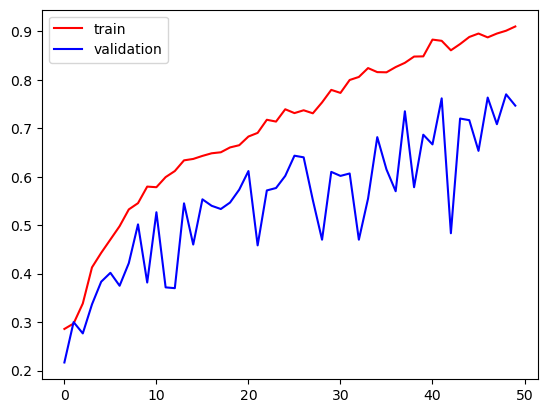

In [8]:
plt.plot(t_m.history['accuracy'],color='red',label='train')
plt.plot(t_m.history['val_accuracy'],color='blue',label='validation')
plt.legend()
plt.show()

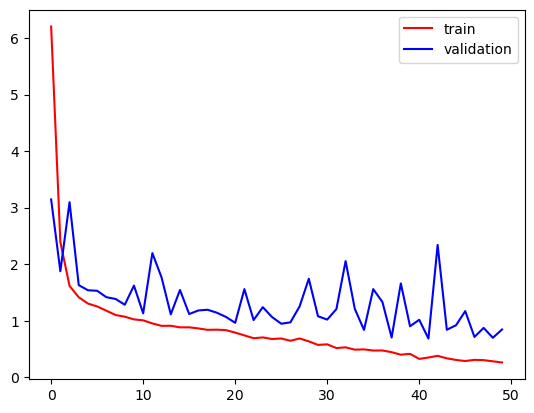

In [9]:
plt.plot(t_m.history['loss'],color='red',label='train')
plt.plot(t_m.history['val_loss'],color='blue',label='validation')
plt.legend()
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 236ms/step


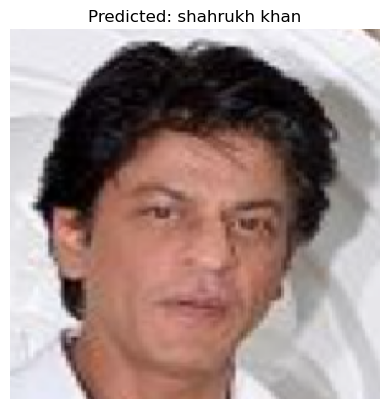

Predicted Class: shahrukh khan


In [10]:

def predict_single_image(img_path, model, class_names):

    img = image.load_img(img_path, target_size=(224, 224))


    img_array = image.img_to_array(img) / 255.0 
    img_array = np.expand_dims(img_array, axis=0) 
    

    prediction = model.predict(img_array)
    predicted_class_index = np.argmax(prediction)
    predicted_class = class_names[predicted_class_index]


    plt.imshow(img)
    plt.title(f"Predicted: {predicted_class}")
    plt.axis('off')
    plt.show()
    
    return predicted_class


img_path = 'test_srk.png'
class_names = ['alia bhatt','deepika padukone','priyanka chopra','shahrukh khan','virat kohli']  # The class names

predicted_class = predict_single_image(img_path, model, class_names)
print(f"Predicted Class: {predicted_class}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


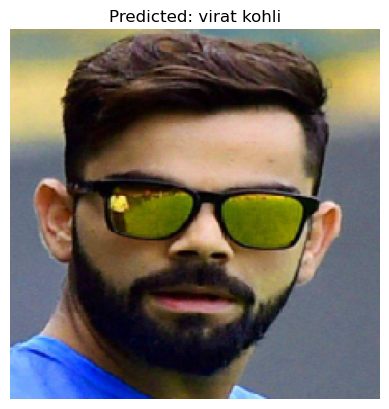

Predicted Class: virat kohli


In [12]:
def predict_single_image(img_path, model, class_names):

    img = image.load_img(img_path, target_size=(224, 224))


    img_array = image.img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)
    
    prediction = model.predict(img_array)
    predicted_class_index = np.argmax(prediction)
    predicted_class = class_names[predicted_class_index]


    plt.imshow(img)
    plt.title(f"Predicted: {predicted_class}")
    plt.axis('off')
    plt.show()
    
    return predicted_class


img_path = 'test_virat.png'
class_names = ['alia bhatt','deepika padukone','priyanka chopra','shahrukh khan','virat kohli']


predicted_class = predict_single_image(img_path, model, class_names)
print(f"Predicted Class: {predicted_class}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


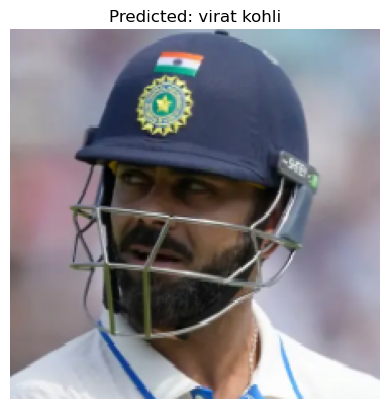

Predicted Class: virat kohli


In [13]:
def predict_single_image(img_path, model, class_names):

    img = image.load_img(img_path, target_size=(224, 224))

    img_array = image.img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)
    
    prediction = model.predict(img_array)
    predicted_class_index = np.argmax(prediction)  
    predicted_class = class_names[predicted_class_index]


    plt.imshow(img)
    plt.title(f"Predicted: {predicted_class}")
    plt.axis('off')
    plt.show()
    
    return predicted_class


img_path = 'test_helmet.png'
class_names = ['alia bhatt','deepika padukone','priyanka chopra','shahrukh khan','virat kohli']


predicted_class = predict_single_image(img_path, model, class_names)
print(f"Predicted Class: {predicted_class}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


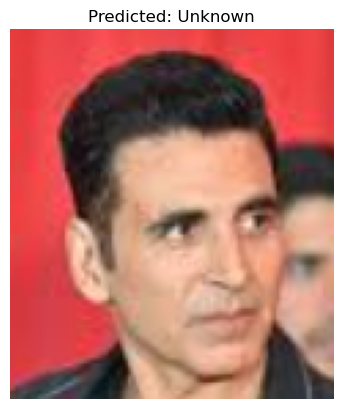

In [15]:
def preprocess_image(image_path, target_size=(224, 224)):
    img = load_img(image_path, target_size=target_size)
    img = img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img /= 255.0
    return img

def classify_with_unknown(model, image, threshold=0.6):
    preds = model.predict(image)
    confidence = np.max(preds)
    
    if confidence < threshold:
        return "Unknown"
    else:
        predicted_class = np.argmax(preds)
        return predicted_class

def predict_uploaded_image(image_path, model, threshold=0.9):
    preprocessed_image = preprocess_image(image_path)

    img = cv.imread(image_path)
    img_rgb = cv.cvtColor(img, cv.COLOR_BGR2RGB)
    plt.imshow(img_rgb)
    plt.axis('off')

    predicted_class = classify_with_unknown(model, preprocessed_image, threshold)

    if predicted_class == "Unknown":
        plt.title("Predicted: Unknown")
    else:
        class_name = train_gen.class_indices
        class_label = list(class_name.keys())[list(class_name.values()).index(predicted_class)]
        plt.title(f"Predicted: {class_label}")

    plt.show()

image_path = "test_unknown.png"
predict_uploaded_image(image_path, model)


### CNN with SGD

In [6]:
model.compile(optimizer='sgd', loss='categorical_crossentropy', metrics=['accuracy'])

In [7]:
m_sgd = model.fit(train_gen, validation_data=val_gen, epochs=50)

Epoch 1/50


C:\Anaconda\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


75/75 ━━━━━━━━━━━━━━━━━━━━ 214s 3s/step - accuracy: 0.3094 - loss: 1.9313 - val_accuracy: 0.2033 - val_loss: 2.3779
Epoch 2/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 219s 3s/step - accuracy: 0.4540 - loss: 1.2521 - val_accuracy: 0.2283 - val_loss: 2.7810
Epoch 3/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 225s 3s/step - accuracy: 0.4807 - loss: 1.1921 - val_accuracy: 0.2117 - val_loss: 1.8993
Epoch 4/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 223s 3s/step - accuracy: 0.5527 - loss: 1.0677 - val_accuracy: 0.3233 - val_loss: 1.5292
Epoch 5/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 198s 3s/step - accuracy: 0.5849 - loss: 1.0296 - val_accuracy: 0.4183 - val_loss: 1.3509
Epoch 6/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 198s 3s/step - accuracy: 0.6082 - loss: 0.9478 - val_accuracy: 0.4350 - val_loss: 1.3900
Epoch 7/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 195s 3s/step - accuracy: 0.6012 - loss: 0.9419 - val_accuracy: 0.5017 - val_loss: 1.2771
Epoch 8/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 195s 3s/step - accuracy: 0.6099 - loss: 0.9189 - val_accuracy: 0.5350 - val_loss: 1.

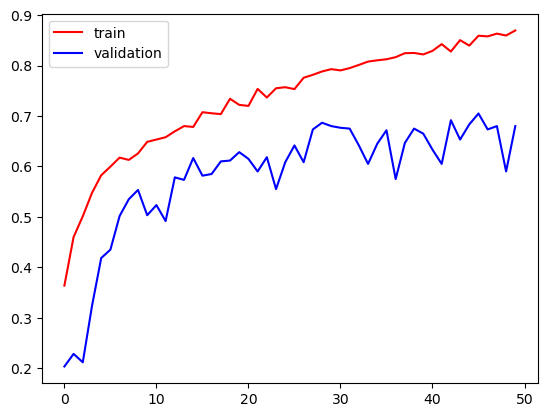

In [8]:
plt.plot(m_sgd.history['accuracy'],color='red',label='train')
plt.plot(m_sgd.history['val_accuracy'],color='blue',label='validation')
plt.legend()
plt.show()

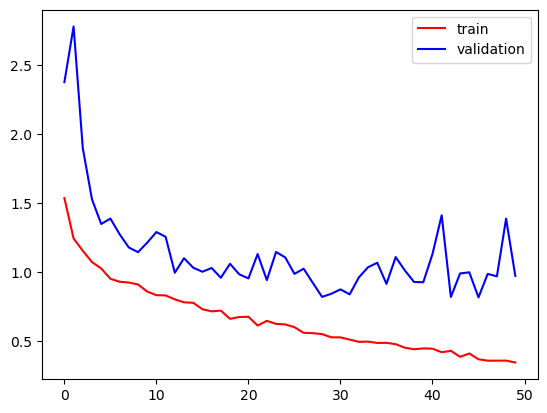

In [9]:
plt.plot(m_sgd.history['loss'],color='red',label='train')
plt.plot(m_sgd.history['val_loss'],color='blue',label='validation')
plt.legend()
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 419ms/step


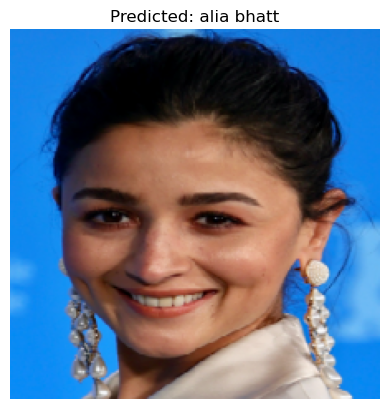

Predicted Class: alia bhatt


In [10]:
def predict_single_image(img_path, model, class_names):

    img = image.load_img(img_path, target_size=(224, 224))

    img_array = image.img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)
    
    prediction = model.predict(img_array)
    predicted_class_index = np.argmax(prediction)  
    predicted_class = class_names[predicted_class_index]


    plt.imshow(img)
    plt.title(f"Predicted: {predicted_class}")
    plt.axis('off')
    plt.show()
    
    return predicted_class


img_path = 'test_alia.png'
class_names = ['alia bhatt','deepika padukone','priyanka chopra','shahrukh khan','virat kohli']


predicted_class = predict_single_image(img_path, model, class_names)
print(f"Predicted Class: {predicted_class}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


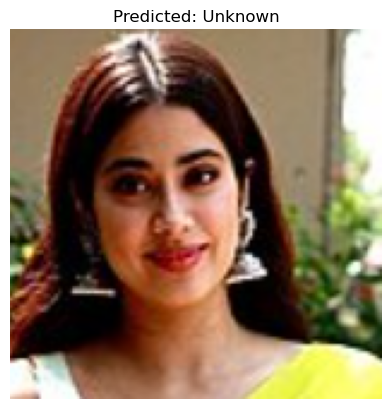

In [11]:
def preprocess_image(image_path, target_size=(224, 224)):
    img = load_img(image_path, target_size=target_size)
    img = img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img /= 255.0
    return img

def classify_with_unknown(model, image, threshold=0.6):
    preds = model.predict(image)
    confidence = np.max(preds)
    
    if confidence < threshold:
        return "Unknown"
    else:
        predicted_class = np.argmax(preds)
        return predicted_class

def predict_uploaded_image(image_path, model, threshold=0.9):
    preprocessed_image = preprocess_image(image_path)

    img = cv.imread(image_path)
    img_rgb = cv.cvtColor(img, cv.COLOR_BGR2RGB)
    plt.imshow(img_rgb)
    plt.axis('off')

    predicted_class = classify_with_unknown(model, preprocessed_image, threshold)

    if predicted_class == "Unknown":
        plt.title("Predicted: Unknown")
    else:
        class_name = train_gen.class_indices
        class_label = list(class_name.keys())[list(class_name.values()).index(predicted_class)]
        plt.title(f"Predicted: {class_label}")

    plt.show()

image_path = "test_unknown2.png"
predict_uploaded_image(image_path, model)


### AlexNet

In [18]:
model_a = Sequential()
model_a.add(Conv2D(96, (11, 11), strides=4, activation='relu', input_shape=(224,224,3)))
model_a.add(BatchNormalization())
model_a.add(MaxPool2D((3, 3), strides=2))

model_a.add(Conv2D(256, (5, 5), padding='same', activation='relu'))
model_a.add(BatchNormalization())
model_a.add(MaxPool2D((3, 3), strides=2))

model_a.add(Conv2D(384, (3, 3), padding='same', activation='relu'))
model_a.add(BatchNormalization())
model_a.add(Conv2D(384, (3, 3), padding='same', activation='relu'))
model_a.add(BatchNormalization())
model_a.add(Conv2D(256, (3, 3), padding='same', activation='relu'))
model_a.add(BatchNormalization())
model_a.add(MaxPool2D((3, 3), strides=2))

model_a.add(Flatten())
model_a.add(Dense(2048, activation='relu'))
model_a.add(Dropout(0.5))
model_a.add(Dense(2048, activation='relu'))
model_a.add(Dropout(0.5))
model_a.add(Dense(5, activation='softmax'))

In [19]:
model_a.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_11 (Conv2D)                   │ (None, 54, 54, 96)          │          34,944 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_11               │ (None, 54, 54, 96)          │             384 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 26, 26, 96)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_12 (Conv2D)                   │ (None, 26, 26, 256)         │         614,656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_12               │ (None, 26, 26, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (None, 12, 12, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_13 (Conv2D)                   │ (None, 12, 12, 384)         │         885,120 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_13               │ (None, 12, 12, 384)         │           1,536 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_14 (Conv2D)                   │ (None, 12, 12, 384)         │       1,327,488 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_14               │ (None, 12, 12, 384)         │           1,536 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_15 (Conv2D)                   │ (None, 12, 12, 256)         │         884,992 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_15               │ (None, 12, 12, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_8 (MaxPooling2D)       │ (None, 5, 5, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 6400)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 2048)                │      13,109,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 2048)                │       4,196,352 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 5)                   │          10,2

 Total params: 21,068,549 (80.37 MB)

 Trainable params: 21,065,797 (80.36 MB)

 Non-trainable params: 2,752 (10.75 KB)

In [20]:
model_a.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [21]:
alex=model_a.fit(train_gen,validation_data=val_gen,epochs=50)

Epoch 1/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 70s 863ms/step - accuracy: 0.2360 - loss: 12.1230 - val_accuracy: 0.1717 - val_loss: 4.6881
Epoch 2/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 66s 858ms/step - accuracy: 0.3008 - loss: 2.0655 - val_accuracy: 0.2933 - val_loss: 1.5956
Epoch 3/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 67s 860ms/step - accuracy: 0.3466 - loss: 1.6291 - val_accuracy: 0.2350 - val_loss: 1.8411
Epoch 4/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 67s 861ms/step - accuracy: 0.3704 - loss: 1.4890 - val_accuracy: 0.4283 - val_loss: 1.2977
Epoch 5/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 67s 862ms/step - accuracy: 0.4153 - loss: 1.3809 - val_accuracy: 0.3917 - val_loss: 1.3675
Epoch 6/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 67s 862ms/step - accuracy: 0.4129 - loss: 1.3639 - val_accuracy: 0.3083 - val_loss: 1.6026
Epoch 7/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 67s 863ms/step - accuracy: 0.4195 - loss: 1.3365 - val_accuracy: 0.3750 - val_loss: 1.4322
Epoch 8/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 67s 863ms/step - accuracy: 0.4371 - loss: 1.3341 - val_acc

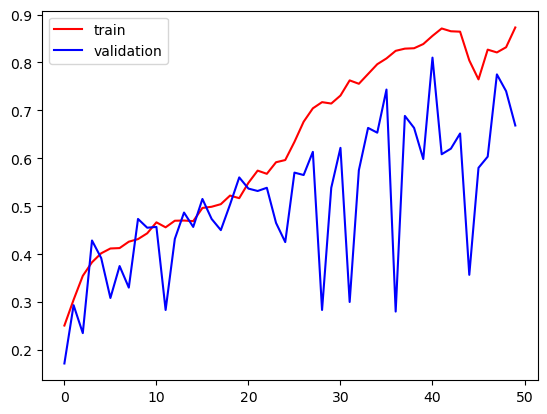

In [22]:
plt.plot(alex.history['accuracy'],color='red',label='train')
plt.plot(alex.history['val_accuracy'],color='blue',label='validation')
plt.legend()
plt.show()

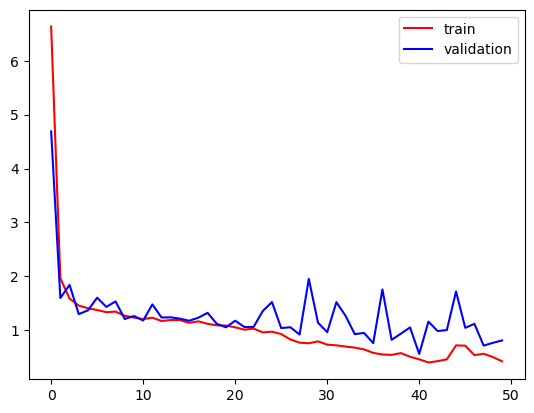

In [23]:
plt.plot(alex.history['loss'],color='red',label='train')
plt.plot(alex.history['val_loss'],color='blue',label='validation')
plt.legend()
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step


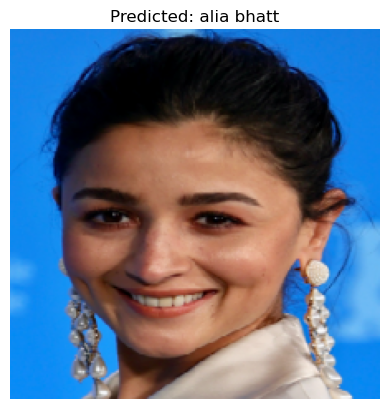

Predicted Class: alia bhatt


In [24]:
def predict_single_image(img_path, model, class_names):

    img = image.load_img(img_path, target_size=(224, 224))

    img_array = image.img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)
    
    prediction = model.predict(img_array)
    predicted_class_index = np.argmax(prediction)  
    predicted_class = class_names[predicted_class_index]


    plt.imshow(img)
    plt.title(f"Predicted: {predicted_class}")
    plt.axis('off')
    plt.show()
    
    return predicted_class


img_path = 'test_alia.png'
class_names = ['alia bhatt','deepika padukone','priyanka chopra','shahrukh khan','virat kohli']


predicted_class = predict_single_image(img_path, model_a, class_names)
print(f"Predicted Class: {predicted_class}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


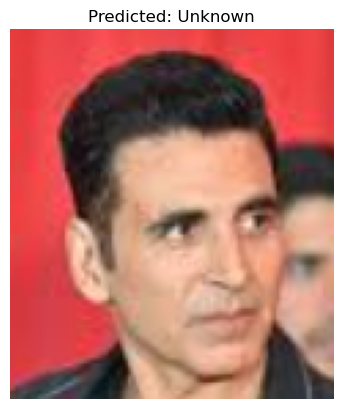

In [25]:
def preprocess_image(image_path, target_size=(224, 224)):
    img = load_img(image_path, target_size=target_size)
    img = img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img /= 255.0
    return img

def classify_with_unknown(model, image, threshold=0.6):
    preds = model.predict(image)
    confidence = np.max(preds)
    
    if confidence < threshold:
        return "Unknown"
    else:
        predicted_class = np.argmax(preds)
        return predicted_class

def predict_uploaded_image(image_path, model, threshold=0.9):
    preprocessed_image = preprocess_image(image_path)

    img = cv.imread(image_path)
    img_rgb = cv.cvtColor(img, cv.COLOR_BGR2RGB)
    plt.imshow(img_rgb)
    plt.axis('off')

    predicted_class = classify_with_unknown(model, preprocessed_image, threshold)

    if predicted_class == "Unknown":
        plt.title("Predicted: Unknown")
    else:
        class_name = train_gen.class_indices
        class_label = list(class_name.keys())[list(class_name.values()).index(predicted_class)]
        plt.title(f"Predicted: {class_label}")

    plt.show()

image_path = "test_unknown.png"
predict_uploaded_image(image_path, model_a)


### densenet121

In [4]:
base_model = DenseNet121(include_top=False, weights='imagenet', input_shape=(224, 224, 3))
x = Flatten()(base_model.output)
x = Dense(512, activation='relu')(x)
x = BatchNormalization()(x)
x = Dense(256, activation='relu')(x)
x = BatchNormalization()(x)
x = Dense(128, activation='relu')(x)
x = BatchNormalization()(x)
x = Dense(5, activation='softmax')(x)
dense = Model(inputs=base_model.input, outputs=x)

In [5]:
dense.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [6]:
dense.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)      │ (None, 224, 224, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ zero_padding2d                │ (None, 230, 230, 3)       │               0 │ input_layer[0][0]          │
│ (ZeroPadding2D)               │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1_conv (Conv2D)           │ (None, 112, 112, 64)      │           9,408 │ zero_padding2d[0][0]       │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1_bn (BatchNormalization) │ (None, 112, 112, 64)      │             256 │ conv1_conv[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1_relu (Activation)       │ (None, 112, 112, 64)      │               0 │ conv1_bn[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ zero_padding2d_1              │ (None, 114, 114, 64)      │               0 │ conv1_relu[0][0]           │
│ (ZeroPadding2D)               │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ pool1 (MaxPooling2D)          │ (None, 56, 56, 64)        │               0 │ zero_padding2d_1[0][0]     │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_0_bn             │ (None, 56, 56, 64)        │             256 │ pool1[0][0]                │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_0_relu           │ (None, 56, 56, 64)        │               0 │ conv2_block1_0_bn[0][0]    │
│ (Activation)                  │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_1_conv (Conv2D)  │ (None, 56, 56, 128)       │           8,192 │ conv2_block1_0_relu[0][0]  │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_1_bn             │ (None, 56, 56, 128)       │             512 │ conv2_block1_1_conv[0][0]  │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_1_relu           │ (None, 56, 56, 128)       │               0 │ conv2_block1_1_bn[0][0]    │
│ (Activation)                  │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_2_conv (Conv2D)  │ (None, 56, 56, 32)        │          36,864 │ conv2_block1_1_relu[0][0]  │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_concat           │ (None, 56, 56, 96)        │               0 │ pool1[0][0],               │
│ (Concatenate)                 │                           │               

 Total params: 32,896,581 (125.49 MB)

 Trainable params: 32,811,141 (125.16 MB)

 Non-trainable params: 85,440 (333.75 KB)

In [7]:
dense_m=dense.fit(train_gen,validation_data=val_gen,epochs=8)

Epoch 1/8


C:\Anaconda\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


75/75 ━━━━━━━━━━━━━━━━━━━━ 507s 6s/step - accuracy: 0.5176 - loss: 1.3261 - val_accuracy: 0.3767 - val_loss: 1.8901
Epoch 2/8
75/75 ━━━━━━━━━━━━━━━━━━━━ 442s 6s/step - accuracy: 0.8515 - loss: 0.3938 - val_accuracy: 0.6067 - val_loss: 1.3956
Epoch 3/8
75/75 ━━━━━━━━━━━━━━━━━━━━ 444s 6s/step - accuracy: 0.9159 - loss: 0.2577 - val_accuracy: 0.4450 - val_loss: 2.9241
Epoch 4/8
75/75 ━━━━━━━━━━━━━━━━━━━━ 441s 6s/step - accuracy: 0.9207 - loss: 0.2385 - val_accuracy: 0.8600 - val_loss: 0.5028
Epoch 5/8
75/75 ━━━━━━━━━━━━━━━━━━━━ 439s 6s/step - accuracy: 0.9489 - loss: 0.1655 - val_accuracy: 0.6567 - val_loss: 1.4072
Epoch 6/8
75/75 ━━━━━━━━━━━━━━━━━━━━ 440s 6s/step - accuracy: 0.9392 - loss: 0.1756 - val_accuracy: 0.8317 - val_loss: 0.5011
Epoch 7/8
75/75 ━━━━━━━━━━━━━━━━━━━━ 439s 6s/step - accuracy: 0.9537 - loss: 0.1481 - val_accuracy: 0.7183 - val_loss: 1.1788
Epoch 8/8
75/75 ━━━━━━━━━━━━━━━━━━━━ 440s 6s/step - accuracy: 0.9537 - loss: 0.1355 - val_accuracy: 0.7867 - val_loss: 0.7765


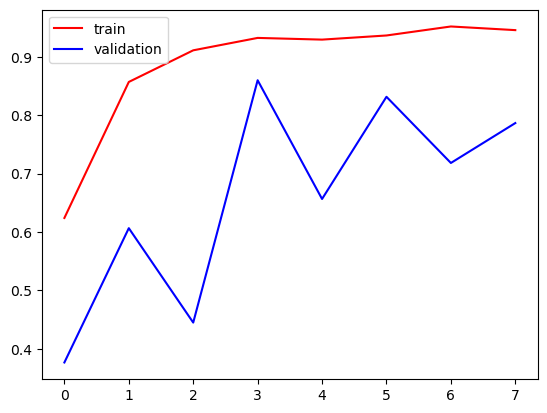

In [8]:
plt.plot(dense_m.history['accuracy'],color='red',label='train')
plt.plot(dense_m.history['val_accuracy'],color='blue',label='validation')
plt.legend()
plt.show()

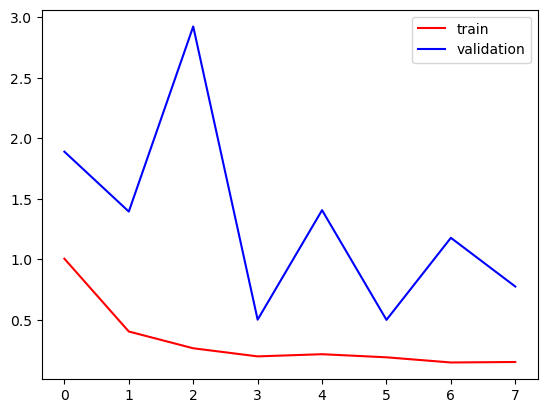

In [9]:
plt.plot(dense_m.history['loss'],color='red',label='train')
plt.plot(dense_m.history['val_loss'],color='blue',label='validation')
plt.legend()
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


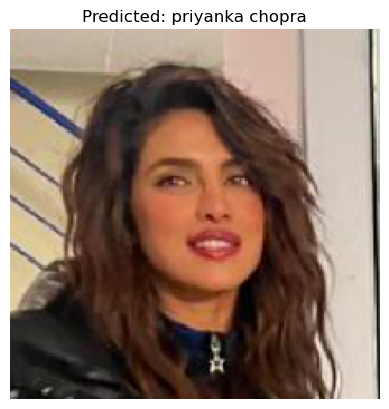

Predicted Class: priyanka chopra


In [10]:
def predict_single_image(img_path, model, class_names):

    img = image.load_img(img_path, target_size=(224, 224))

    img_array = image.img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)
    
    prediction = model.predict(img_array)
    predicted_class_index = np.argmax(prediction)  
    predicted_class = class_names[predicted_class_index]


    plt.imshow(img)
    plt.title(f"Predicted: {predicted_class}")
    plt.axis('off')
    plt.show()
    
    return predicted_class


img_path = 'test_priyanka.png'
class_names = ['alia bhatt','deepika padukone','priyanka chopra','shahrukh khan','virat kohli']


predicted_class = predict_single_image(img_path, dense, class_names)
print(f"Predicted Class: {predicted_class}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step


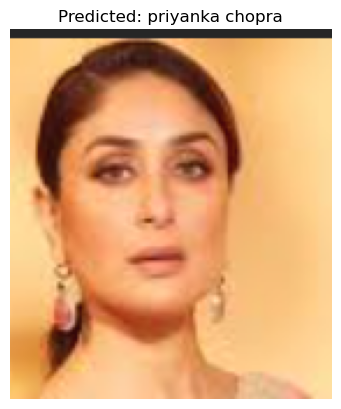

In [21]:
def preprocess_image(image_path, target_size=(224, 224)):
    img = load_img(image_path, target_size=target_size)
    img = img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img /= 255.0
    return img

def classify_with_unknown(model, image, threshold=0.9):
    preds = model.predict(image)
    confidence = np.max(preds)
    
    if confidence < threshold:
        return "Unknown"
    else:
        predicted_class = np.argmax(preds)
        return predicted_class

def predict_uploaded_image(image_path, model, threshold=0.9):
    preprocessed_image = preprocess_image(image_path)

    img = cv.imread(image_path)
    img_rgb = cv.cvtColor(img, cv.COLOR_BGR2RGB)
    plt.imshow(img_rgb)
    plt.axis('off')

    predicted_class = classify_with_unknown(model, preprocessed_image, threshold)

    if predicted_class == "Unknown":
        plt.title("Predicted: Unknown")
    else:
        class_name = train_gen.class_indices
        class_label = list(class_name.keys())[list(class_name.values()).index(predicted_class)]
        plt.title(f"Predicted: {class_label}")

    plt.show()

image_path = "test_unknown3.png"
predict_uploaded_image(image_path, dense)


### VGG19

In [4]:
base_model = VGG19(include_top=False, weights='imagenet', input_shape=(224,224,3))
x = Flatten()(base_model.output)
x = Dense(512, activation='relu')(x)
x = BatchNormalization()(x)
x = Dense(256, activation='relu')(x)
x = BatchNormalization()(x)
x = Dense(128, activation='relu')(x)
x = BatchNormalization()(x)
x = Dense(5, activation='softmax')(x)
vgg = Model(inputs=base_model.input, outputs=x)

In [5]:
vgg.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [6]:
vgg.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv4 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv4 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv4 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 33,038,405 (126.03 MB)

 Trainable params: 33,036,613 (126.02 MB)

 Non-trainable params: 1,792 (7.00 KB)

In [10]:
early_stopping = EarlyStopping(monitor='loss', patience=5, restore_best_weights=True)

In [11]:
vgg_m=vgg.fit(train_gen,validation_data=val_gen,epochs=50,callbacks=[early_stopping])

Epoch 1/50


C:\Anaconda\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


75/75 ━━━━━━━━━━━━━━━━━━━━ 1014s 13s/step - accuracy: 0.2292 - loss: 1.8701 - val_accuracy: 0.2000 - val_loss: 25.5103
Epoch 2/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 1116s 15s/step - accuracy: 0.3089 - loss: 1.5631 - val_accuracy: 0.3333 - val_loss: 1.8170
Epoch 3/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 1117s 15s/step - accuracy: 0.3581 - loss: 1.4778 - val_accuracy: 0.2000 - val_loss: 10.0265
Epoch 4/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 1149s 15s/step - accuracy: 0.3759 - loss: 1.4156 - val_accuracy: 0.2350 - val_loss: 2.0588
Epoch 5/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 1219s 16s/step - accuracy: 0.4096 - loss: 1.3189 - val_accuracy: 0.2933 - val_loss: 1.7966
Epoch 6/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 1255s 17s/step - accuracy: 0.3940 - loss: 1.3528 - val_accuracy: 0.3167 - val_loss: 14676.5312
Epoch 7/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 1250s 17s/step - accuracy: 0.4048 - loss: 1.2840 - val_accuracy: 0.3333 - val_loss: 2136542.0000
Epoch 8/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 1231s 16s/step - accuracy: 0.4355 - loss: 1.2800 - val_acc

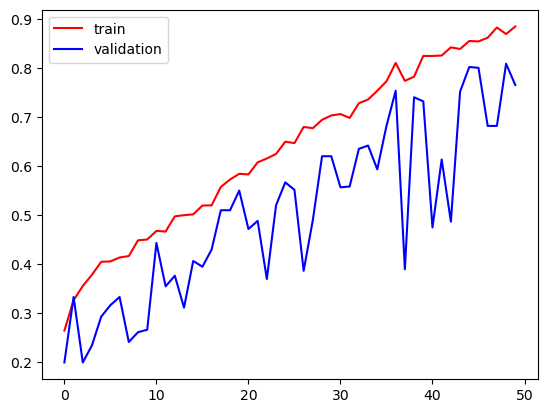

In [12]:
plt.plot(vgg_m.history['accuracy'],color='red',label='train')
plt.plot(vgg_m.history['val_accuracy'],color='blue',label='validation')
plt.legend()
plt.show()

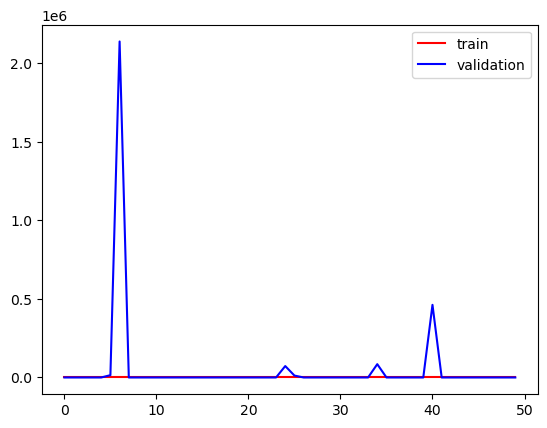

In [13]:
plt.plot(vgg_m.history['loss'],color='red',label='train')
plt.plot(vgg_m.history['val_loss'],color='blue',label='validation')
plt.legend()
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 527ms/step


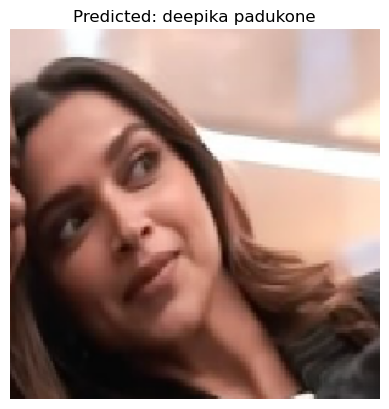

Predicted Class: deepika padukone


In [14]:
def predict_single_image(img_path, model, class_names):

    img = image.load_img(img_path, target_size=(224, 224))

    img_array = image.img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)
    
    prediction = model.predict(img_array)
    predicted_class_index = np.argmax(prediction)  
    predicted_class = class_names[predicted_class_index]


    plt.imshow(img)
    plt.title(f"Predicted: {predicted_class}")
    plt.axis('off')
    plt.show()
    
    return predicted_class


img_path = 'test_d.png'
class_names = ['alia bhatt','deepika padukone','priyanka chopra','shahrukh khan','virat kohli']


predicted_class = predict_single_image(img_path, vgg, class_names)
print(f"Predicted Class: {predicted_class}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step


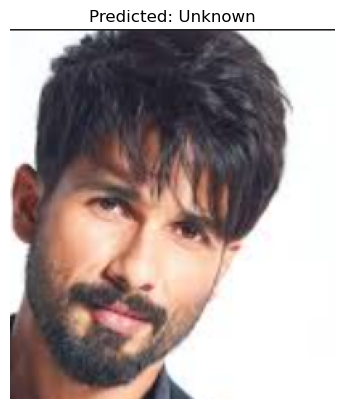

In [16]:
def preprocess_image(image_path, target_size=(224, 224)):
    img = load_img(image_path, target_size=target_size)
    img = img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img /= 255.0
    return img

def classify_with_unknown(model, image, threshold=0.9):
    preds = model.predict(image)
    confidence = np.max(preds)
    
    if confidence < threshold:
        return "Unknown"
    else:
        predicted_class = np.argmax(preds)
        return predicted_class

def predict_uploaded_image(image_path, model, threshold=0.9):
    preprocessed_image = preprocess_image(image_path)

    img = cv.imread(image_path)
    img_rgb = cv.cvtColor(img, cv.COLOR_BGR2RGB)
    plt.imshow(img_rgb)
    plt.axis('off')

    predicted_class = classify_with_unknown(model, preprocessed_image, threshold)

    if predicted_class == "Unknown":
        plt.title("Predicted: Unknown")
    else:
        class_name = train_gen.class_indices
        class_label = list(class_name.keys())[list(class_name.values()).index(predicted_class)]
        plt.title(f"Predicted: {class_label}")

    plt.show()

image_path = "test_unknown4.png"
predict_uploaded_image(image_path, vgg)


### ANN

In [4]:
ann_model = Sequential()
ann_model.add(Flatten(input_shape=(224, 224, 3)))
ann_model.add(Dense(512, activation='relu'))
ann_model.add(Dense(256, activation='relu'))
ann_model.add(Dense(128, activation='relu'))
ann_model.add(Dense(5, activation='softmax'))

C:\Anaconda\Lib\site-packages\keras\src\layers\reshaping\flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [5]:
ann_model.compile(optimizer="adam", loss='categorical_crossentropy', metrics=['accuracy'])

In [6]:
ann_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ flatten (Flatten)                    │ (None, 150528)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │      77,070,848 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 5)                   │             645 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 77,235,717 (294.63 MB)

 Trainable params: 77,235,717 (294.63 MB)

 Non-trainable params: 0 (0.00 B)

In [7]:
ann = ann_model.fit(train_gen, validation_data=val_gen, epochs=50)

Epoch 1/50


C:\Anaconda\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


75/75 ━━━━━━━━━━━━━━━━━━━━ 61s 769ms/step - accuracy: 0.2240 - loss: 28.2108 - val_accuracy: 0.2300 - val_loss: 4.5146
Epoch 2/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 58s 745ms/step - accuracy: 0.2908 - loss: 3.8410 - val_accuracy: 0.3167 - val_loss: 1.9156
Epoch 3/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 57s 734ms/step - accuracy: 0.2906 - loss: 3.7870 - val_accuracy: 0.2533 - val_loss: 1.7616
Epoch 4/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 65s 846ms/step - accuracy: 0.3036 - loss: 1.8868 - val_accuracy: 0.2533 - val_loss: 2.8008
Epoch 5/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 67s 866ms/step - accuracy: 0.3281 - loss: 1.8677 - val_accuracy: 0.3550 - val_loss: 1.8454
Epoch 6/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 67s 868ms/step - accuracy: 0.3254 - loss: 1.7219 - val_accuracy: 0.3467 - val_loss: 1.5769
Epoch 7/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 68s 871ms/step - accuracy: 0.3152 - loss: 1.6387 - val_accuracy: 0.3933 - val_loss: 1.3886
Epoch 8/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 68s 873ms/step - accuracy: 0.3764 - loss: 1.4904 - val_accuracy: 0.33

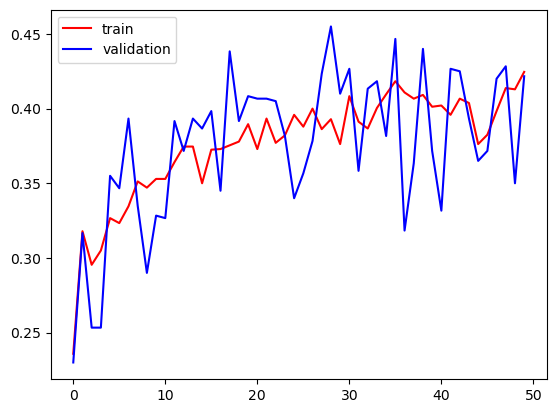

In [8]:
plt.plot(ann.history['accuracy'],color='red',label='train')
plt.plot(ann.history['val_accuracy'],color='blue',label='validation')
plt.legend()
plt.show()

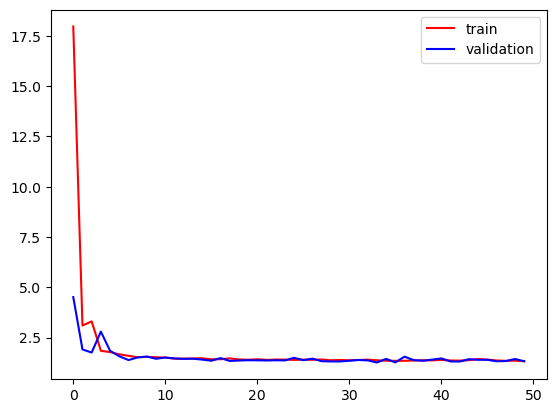

In [9]:
plt.plot(ann.history['loss'],color='red',label='train')
plt.plot(ann.history['val_loss'],color='blue',label='validation')
plt.legend()
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


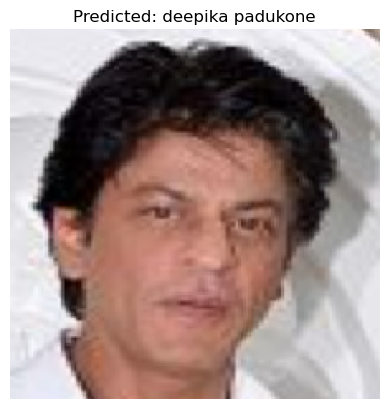

Predicted Class: deepika padukone


In [10]:
def predict_single_image(img_path, model, class_names):

    img = image.load_img(img_path, target_size=(224, 224))

    img_array = image.img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)
    
    prediction = model.predict(img_array)
    predicted_class_index = np.argmax(prediction)  
    predicted_class = class_names[predicted_class_index]


    plt.imshow(img)
    plt.title(f"Predicted: {predicted_class}")
    plt.axis('off')
    plt.show()
    
    return predicted_class


img_path = 'test_srk.png'
class_names = ['alia bhatt','deepika padukone','priyanka chopra','shahrukh khan','virat kohli']


predicted_class = predict_single_image(img_path, ann_model, class_names)
print(f"Predicted Class: {predicted_class}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


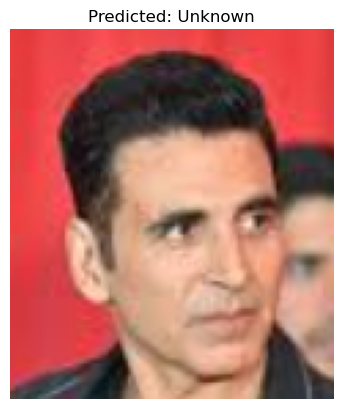

In [12]:
def preprocess_image(image_path, target_size=(224, 224)):
    img = load_img(image_path, target_size=target_size)
    img = img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img /= 255.0
    return img

def classify_with_unknown(model, image, threshold=0.9):
    preds = model.predict(image)
    confidence = np.max(preds)
    
    if confidence < threshold:
        return "Unknown"
    else:
        predicted_class = np.argmax(preds)
        return predicted_class

def predict_uploaded_image(image_path, model, threshold=0.9):
    preprocessed_image = preprocess_image(image_path)

    img = cv.imread(image_path)
    img_rgb = cv.cvtColor(img, cv.COLOR_BGR2RGB)
    plt.imshow(img_rgb)
    plt.axis('off')

    predicted_class = classify_with_unknown(model, preprocessed_image, threshold)

    if predicted_class == "Unknown":
        plt.title("Predicted: Unknown")
    else:
        class_name = train_gen.class_indices
        class_label = list(class_name.keys())[list(class_name.values()).index(predicted_class)]
        plt.title(f"Predicted: {class_label}")

    plt.show()

image_path = "test_unknown.png"
predict_uploaded_image(image_path, ann_model)
